In [1]:
import pandas as pd
import numpy as np
import time
import aggfly as af

project_dir = '/home3/dth2133/data/clim_data_requests/maya'

In [2]:
# Years to aggregate
years = np.arange(1951,1953)

# Load shapefile
georegions = af.georegions_from_path(
    "/home3/dth2133/data/shapefiles/county/cb_2018_us_county_500k.shp",
    regionid='GEOID'
)

In [8]:
# Open example dataset to construct weights.
dataset = af.dataset_from_path(
    f"/home3/dth2133/data/annual/tempPrecLand2018.zarr", 
    var = 't2m',
    name = 'era5',
    georegions=georegions,
    preprocess = lambda x: (x - 273.15)
)

# Calculate area weights.
weights = af.weights_from_objects(
    dataset,
    georegions,
    wtype=None,
    project_dir=project_dir
)
weights.calculate_weights()

/home3/dth2133/data/clim_data_requests/maya/tmp/GridWeights/mod-3bca46df924d347
Loading rescaled weights from cache
Cache dictionary:
{'func': 'weights', 'raster_weights': None}


In [ ]:
df = pd.DataFrame()
for year in years:
    
    start = time.time()
    
    dataset = af.dataset_from_path(
        f"/home3/dth2133/data/annual/tempPrecLand{year}.zarr", 
        var = 't2m',
        name = 'era5',
        georegions=georegions,
        preprocess = lambda x: (x - 273.15)
    )
    
    output_df = af.aggregate_dataset(
        dataset=dataset, 
        weights=weights,
        tavg = {
            'aggregate': {'calc':'mean', 'groupby':'day'},
            'transform': {'transform':'power', 'exp':np.arange(1,3)},
            'aggregate': {'caalc':'sum', 'groupby':'year'},
        },
        bins={
            'aggregate':{'calc':'avg', 'groupby':'date'},
            'aggregate':{'calc':'bins', 'groupby':'year', 'ddargs':[[25,99,0],[30,99,0]]}
        },
        heating_dday = {
            'aggregate':{'calc':'dd', 'groupby':'date', 'ddargs':[-99,20,1]},
            'aggregate': {'calc':'sum', 'groupby':'year'},
        }
    )
    
    df = pd.concat([df, output_df], axis=0)
    end = time.time()
    print(f"Year {year} took {end-start} seconds.")



COMPUTING
[########################################] | 100% Completed | 100.59 s
[########################################] | 100% Completed | 500.17 ms
Year 1951 took 102.18754315376282 seconds.
COMPUTING
[########################################] | 100% Completed | 205.10 s
[########################################] | 100% Completed | 365.84 ms
Year 1952 took 206.5074827671051 seconds.


<Axes: >

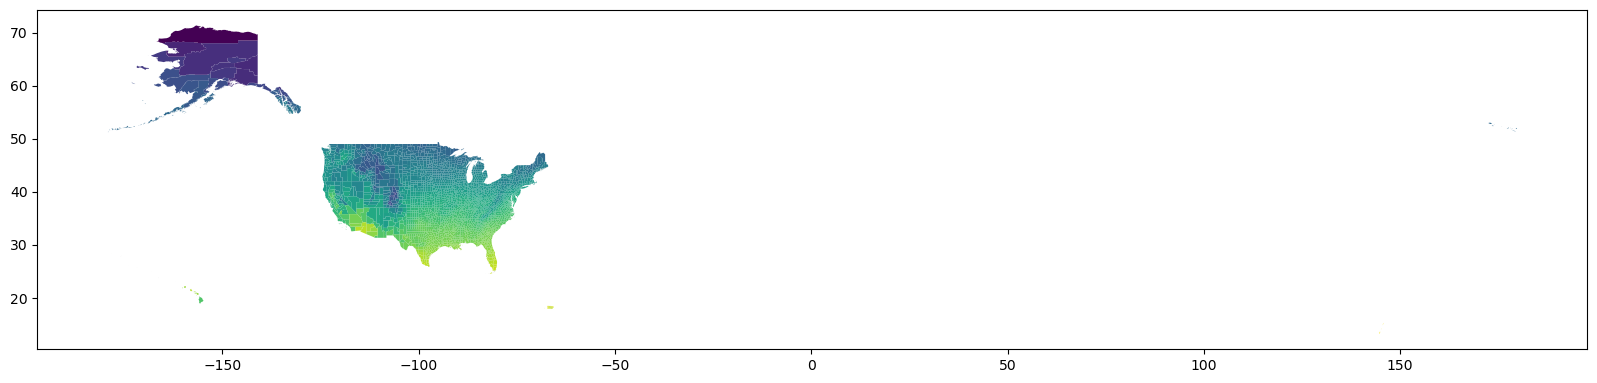

In [ ]:
slc = out.loc[out.year==1951].groupby('GEOID').mean()
georegions.shp.merge(slc, right_index=True, left_on='GEOID').plot(column='avg')